This example showcases highly modular use of defSim.

In [1]:
import defSim as ds
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import networkx as nx
import random
import copy

from IPython.display import Image
from IPython.core.display import HTML

In [62]:
def plot_by_color(network, feature = 'f01', title = None, pos = None):
    nodes = network.nodes()

    colors = [network.nodes[n][feature] for n in nodes]

    # drawing nodes and edges separately so we can capture collection for colobar
    plt.figure(1,figsize=(7,7))
    if pos is None:
        pos = nx.spring_layout(network)
    ec = nx.draw_networkx_edges(network, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(network, pos, nodelist=nodes, node_color=colors, 
                                with_labels=False, node_size=100, cmap=plt.cm.winter,
                                vmin=0, vmax=1)
    
    if title is not None:
        plt.title(title)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()

def plot_dynamics(feature, network = None):
    plt.figure(1,figsize=(10,8))
    if network is not None and 'color' in network.nodes[0]:
        colors = [network.nodes[n]['color'] for n in network.nodes]
        feature = np.array(feature).transpose()
        for i in range(len(feature)):
            plt.plot(feature[i], color = colors[i])
    else:
        plt.plot(feature)
    
def plot_experiment(results):
    plt.figure(figsize=[5, 5])
    plt.ylim(0,1.01)
    plt.title('Average opinion distance\nBy when between-group connections are introduced', y=1.04)
    ax = sns.boxplot(x="rewiring_step", y="AverageDistance",
                     data=results, palette='bright', linewidth=3)
    ax.set(ylim=[0, 1],
           xlabel='Step in which rewiring takes place', 
           ylabel='Average opinion distance')

    plt.show()    

## Modular use of defSim: splitting initialization and simulation to allow for network manipulation

In this example, we investigate the impact of an external shock on the opinion dynamics in two initially isolated groups. Our setup is as follows:
- two groups of 10 agents each, which initially are fully internally connected but have no connections to the other group
- one attribute (representing an opinion) on which the average initial value differs slightly between the groups
- 40 rounds of interaction (one-to-many), with an influence function representing argument exchange
- followed by the rewiring of ties to create connections between the two groups
- followed by 40 more rounds of interaction
The outcome of interest is the (change in) average opinion in each group.

#### Our approach
In a standard defSim simulation, the network on which agents interact is static (as of v1.0), being generated in the initialization stage of the simulation. After initialization, the simulation runs through focal and receiving agent selection, influence, and dissimilarity updating stages until convergence.

To implement a one-time change to the network like the one we intend, we will first allow the simulation to initialize, then run as normal for 40 steps, then manipulate the network, and then run for 40 more steps without reinitializing. 

### The simulation (annotated)

In [63]:
sim = ds.Simulation(
    seed = 3838,
    influence_function = "bounded_confidence",   # positive influence, as long as interaction partner is not more dissimilar than the confidence level
    influenceable_attributes = ['f01'],   # only try to influence opinion feature, not the color attribute which we will set for simulation purposes
    communication_regime = 'one-to-many',   # at each step, one focal agent influences all its neighbors
    attributes_initializer = "correlated_continuous",   # by default: one continuous attribute. the choice for the correlated continuous initializer is motivated by the ability to create differences between groups
    dissimilarity_measure = ds.EuclideanDistance(exclude = ['color']),   # dissimilarity is based on euclidean distance, which given one attribute is just the opinion distance between two agents
    topology = "caveman_graph",   # using one of the networkx graph generators, with parameters l and k specified in the parameter dictionary
    max_iterations = 40,   # we run the simulation twice, with 40 steps each time
    parameter_dict = {
        'l': 2,   # number of caves (groups)
        'k': 10,   # number of agents per cave (group)
        'confidence_level': 0.5,   # confidence level for the bounded_confidence influence function
        'neighbor_similarity_postprocessing': 10,   # create similarity between neighbors by applying 10 rounds of postprocessing in which agents who are too dissimilar to their neighbors are moved elsewhere in the network
        'neighbor_similarity_criterion': 0.4   # neighbors are considered too dissimilar if the opinion distance between them is more than 0.5
    },
    tickwise = ['f01']   # store each agent's opinion at every step
)

### Step 1: Initialize the simulation
Although we could choose to immediately run the first 40 steps of our simulation, until the point at which we want to rewire, we prefer to initialize the simulation separately. This way, we can take a look at the network and the opinion of each agent before influence takes place. Below, the simulation is initialized and the initial network is shown. Some difference in average opinion between the two groups is visible, although there is also substantial variation in opinions within each group.

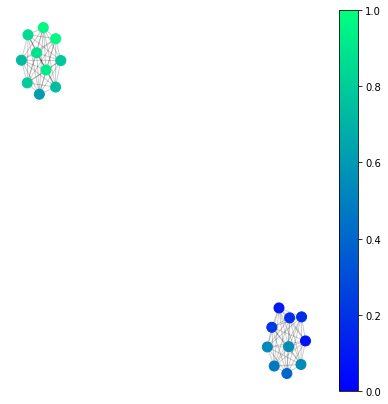

In [64]:
sim.initialize_simulation()
components = [i for i in nx.connected_components(sim.network)]
for node in components[0]:
    sim.network.nodes[node]['color'] = 'blue'
for node in components[1]:
    sim.network.nodes[node]['color'] = 'red'    
plot_by_color(sim.network)

### Step 2: Run the simulation for 40 steps
We now run the first 40 steps of the simulation, in which agents are only connected to others in their own cave. Below, we show the development of each agent's opinion (attribute value on 'f01') over these 40 steps. Results may vary a bit by run, but generally by the end of these 40 steps the two groups have become internally homogeneous while the average opinions of the two groups are clearly different.

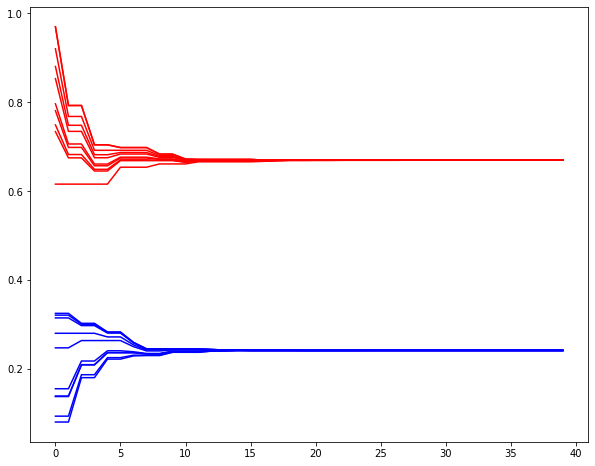

In [65]:
results_before_rewiring = sim.run_simulation(initialize = False)
plot_dynamics(results_before_rewiring['Tickwise_f01'][0], network = sim.network)

### Step 3: Rewiring the network
Now the first stage of the simulation is complete. We next want to restructure the network to create connections between the two groups. One way to achieve this is using Maslov-Sneppen rewiring. In brief, a specified proportion of existing ties in the network are replaced by ties between previously unconnected agents. The total number of ties in the network therefore remains the same, but some previously unconnected agents will be connected. Since in our initial situation all agents within each group are connected and there are no between-group connections, applying Maslov-Sneppen rewiring will effectively create ties between the two groups.

To apply the Maslov-Sneppen rewiring procedure, we can use a network modifier available in defSim which as part of the network evolution module. This modifier can also be applied during network initialization if you set the 'network_modifiers' parameter for the simulation ([see documentation of the Simulation class](https://marijnkeijzer.github.io/defSim/simulation.class.html)). The source code for the Maslov-Sneppen modifier can be found in the [network_evolution_sim module](https://github.com/marijnkeijzer/defSim/blob/master/defSim/network_init/network_init.py). The module is used by first creating an instance of the _MaslovSneppenModifier_ with the proportion of ties to be rewired as an initialization parameter, and then calling its _rewire_network_ function on the simulation network.

After applying Maslov-Sneppen rewiring, some new ties are created which lack a property which is usually set during initialization of the simulation: the (opinion) distance between connected agents ([see code](https://github.com/marijnkeijzer/defSim/blob/master/defSim/network_evolution_sim/MaslovSneppenModifier.py)). Fortunately, the function which calculates this distance can also be called outside of the simulation loop. After doing these two things, the simulation can proceed.

After rewiring, we again visualize the network so you can verify that between-group ties have been added.

(**Note:** given that we used two defSim components which are normally used during initialization, why did we not simply reinitialize the simulation? Well, initializing the simulation does other things as well, such as regenerating all attribute values. We want to continue the simulation with the opinions agents had reached after step 40, so this would not work for us.)

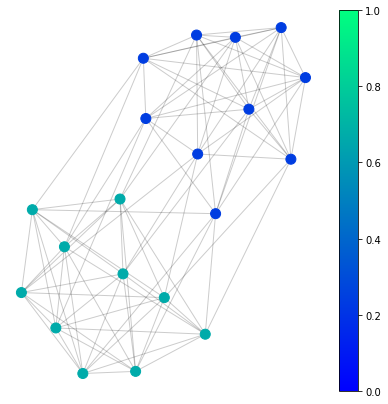

In [66]:
# Rewire 10% of all ties
ds.MaslovSneppenModifier(rewiring_prop = 0.1).rewire_network(network = sim.network)
# Recalculate dissimilarity to neighbors (would otherwise be missing for new ties)
sim.dissimilarity_calculator.calculate_dissimilarity_networkwide(sim.network)
plot_by_color(sim.network)

### Step 4: Run the simulation for another 40 steps
We now run the second set of 40 steps, in which agents are connected to others in their own cave _and_ to the other cave. Below, we show the development of each agent's opinion (attribute value on 'f01') over the total of 80 steps. After step 40, between-group ties were introduced. Results may vary a bit by run, but generally you will see that the two groups eventually converge to the same (rather moderate) average opinion.

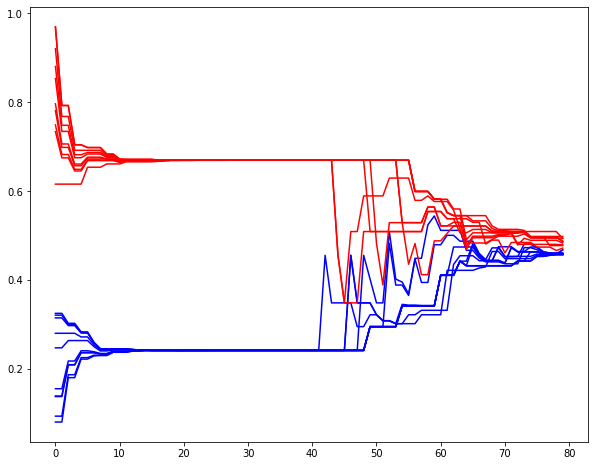

In [67]:
results_after_rewiring = sim.run_simulation(initialize = False)
plot_dynamics(results_after_rewiring['Tickwise_f01'][0], network = sim.network)

### Comparison: connecting groups before interaction
For comparison, let's see what the dynamics of opinion changes would look like if we did not start with a period of exclusively within-group interaction but instead immediately connected two groups. We start by again initializing the simulation, and then immediately rewire some ties to create between-group connections. The initial network is visualized below. Parameters of the simulation are otherwise identical, so the initial groups start off relatively homogeneous in attribute values.

/home/dieko/VENVs/defSim_release/lib/python3.6/site-packages/defSim/agents_init/CorrelatedContinuousInitializer.py:62: UserWarning: Number of features not specified, using 1 as default
  warnings.warn("Number of features not specified, using 1 as default")
/home/dieko/VENVs/defSim_release/lib/python3.6/site-packages/defSim/agents_init/CorrelatedContinuousInitializer.py:108: UserWarning: Neither covariance matrix nor correlation specified, using r = 0 as default
  warnings.warn("Neither covariance matrix nor correlation specified, using r = 0 as default")


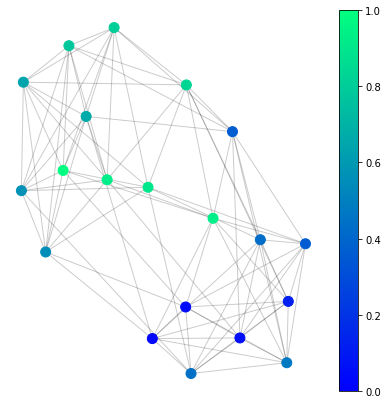

In [72]:
sim_immediate = ds.Simulation(
    seed = 3838,
    influence_function = "bounded_confidence",   # positive influence, as long as interaction partner is not more dissimilar than the confidence level
    influenceable_attributes = ['f01'],   # only try to influence opinion feature, not the color attribute which we will set for simulation purposes
    communication_regime = 'one-to-many',   # at each step, one focal agent influences all its neighbors
    attributes_initializer = "correlated_continuous",   # by default: one continuous attribute. the choice for the correlated continuous initializer is motivated by the ability to create differences between groups
    dissimilarity_measure = ds.EuclideanDistance(exclude = ['color']),   # dissimilarity is based on euclidean distance, which given one attribute is just the opinion distance between two agents
    topology = "caveman_graph",   # using one of the networkx graph generators, with parameters l and k specified in the parameter dictionary
    max_iterations = 40,   # we run the simulation twice, with 40 steps each time
    parameter_dict = {
        'l': 2,   # number of caves (groups)
        'k': 10,   # number of agents per cave (group)
        'confidence_level': 0.5,   # confidence level for the bounded_confidence influence function
        'neighbor_similarity_postprocessing': 10,   # create similarity between neighbors by applying 10 rounds of postprocessing in which agents who are too dissimilar to their neighbors are moved elsewhere in the network
        'neighbor_similarity_criterion': 0.4   # neighbors are considered too dissimilar if the opinion distance between them is more than 0.5
    },
    tickwise = ['f01']   # store each agent's opinion at every step
)

# Initialize simulation 
sim_immediate.initialize_simulation()
components = [i for i in nx.connected_components(sim_immediate.network)]
for node in components[0]:
    sim_immediate.network.nodes[node]['color'] = 'blue'
for node in components[1]:
    sim_immediate.network.nodes[node]['color'] = 'red'    

# Rewire 10% of all ties
ds.MaslovSneppenModifier(rewiring_prop = 0.1).rewire_network(network = sim_immediate.network)

# Recalculate dissimilarity to neighbors (would otherwise be missing for new ties)
sim_immediate.dissimilarity_calculator.calculate_dissimilarity_networkwide(sim_immediate.network)

# Show the network
plot_by_color(sim_immediate.network)

We run this simulation for 40 steps. Results may vary somewhat from run to run, but with the current seed we see that the agents do not converge to one (moderate) opinion value. It is possible that, by first allowing the relatively similar agents in each group to form a relatively moderate consensus and only then introducing connections to another group, initial isolation of the two groups fosters consensus when connections are eventually made.

However, it is also very well possible that this depends on the specific initial opinion values and network structure generated in this simulation. A more systematic approach, an __experiment__ is required. Below, you see an example of how such an experiment could be created.

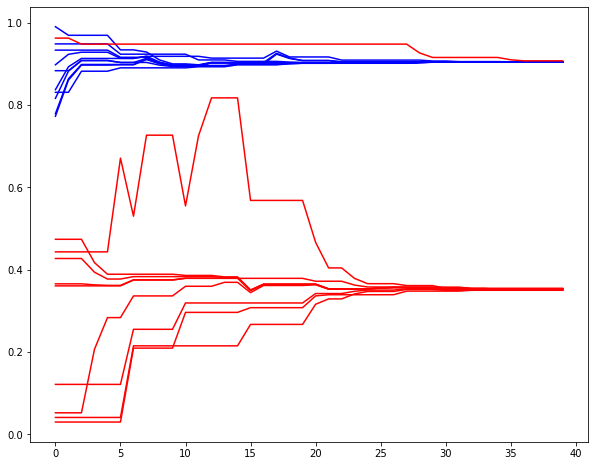

In [73]:
results_immediate_rewiring = sim_immediate.run_simulation(initialize = False)
plot_dynamics(results_immediate_rewiring['Tickwise_f01'][0], network = sim_immediate.network)

## Systematic investigation with an experiment
Given that we have broken the standard simulation loop on which defSim runs, what is the simplest way to perform a systematic experiment in which we compare immediately rewiring ties to rewiring ties after 40 steps? The standard defSim [Experiment](https://marijnkeijzer.github.io/defSim/experiment.class.html) [class](https://marijnkeijzer.github.io/defSim/experiment.class.html) can accomodate running custom Simulation objects, but will always call the run_simulation() function on those Simulations. We have two options, one being to create a class derived from the Simulation base class in which we modify the run_simulation() function, and the other being to emulate the functionality of the experiment class.

#### Simplest: emulating experiment functionality
With a simple for loop we can create and then run simulations with different setups, of which we store and then combine the results. As outcome value, we can track the average opinion distance between connected neighbors (as a rough measure of opinion homogeneity across the network). This is shown below. Results suggest that the result we obtained above, which showed significantly more variation in opinions when between-group connections were immediately introduced, may have been a fluke.

/home/dieko/VENVs/defSim_release/lib/python3.6/site-packages/defSim/agents_init/CorrelatedContinuousInitializer.py:62: UserWarning: Number of features not specified, using 1 as default
  warnings.warn("Number of features not specified, using 1 as default")
/home/dieko/VENVs/defSim_release/lib/python3.6/site-packages/defSim/agents_init/CorrelatedContinuousInitializer.py:108: UserWarning: Neither covariance matrix nor correlation specified, using r = 0 as default
  warnings.warn("Neither covariance matrix nor correlation specified, using r = 0 as default")


Average opinion distance, rewiring_step == 0: 0.0533552211488262
Average opinion distance, rewiring_step == 40: 0.05948779559489975


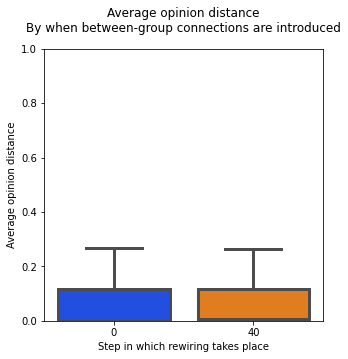

In [10]:
# Generate simulations
## Generate simulations in which we will immediately add between-group ties
sims_immediate = []
for _ in range(50):
    seed = random.randint(1000, 9999)
    new_sim = ds.Simulation(
        seed = seed,
        influence_function = "bounded_confidence",  
        communication_regime = 'one-to-many',  
        attributes_initializer = "correlated_continuous",  
        dissimilarity_measure = "euclidean",  
        topology = "caveman_graph",  
        max_iterations = 40,   
        parameter_dict = {
            'l': 2,  
            'k': 10, 
            'confidence_level': 0.5, 
            'neighbor_similarity_postprocessing': 10,
            'neighbor_similarity_criterion': 0.4,   
            'rewiring_step': 0   # not used during the simulation, but used to identify experimental conditions
        }
    )
    sims_immediate.append(new_sim)
    
## Make a deep copy (also duplicating internal data structures, i.e. the simulations) of the list
## so that we can run the same simulations again with between-group ties added after step 40
sims_delayed = copy.deepcopy(sims_immediate)
for sim_delayed in sims_delayed:
    sim_delayed.parameter_dict['rewiring_step'] = 40

# Run simulations
## Run each simulation with between-group ties immediately added, and store the results
results_immediate = []
for sim_immediate in sims_immediate:
    # Initialize simulation 
    sim_immediate.initialize_simulation()

    # Rewire 10% of all ties
    ds.MaslovSneppenModifier(rewiring_prop = 0.1).rewire_network(network = sim_immediate.network)

    # Recalculate dissimilarity to neighbors (would otherwise be missing for new ties)
    sim_immediate.dissimilarity_calculator.calculate_dissimilarity_networkwide(sim_immediate.network)

    # Run and store results (run twice to get to 80 steps, for consistency)
    sim_immediate.run_simulation(initialize = False)
    results_immediate.append(sim_immediate.run_simulation(initialize = False))
    
## Run each simulation with between-group ties added after step 40
results_delayed = []
for sim_delayed in sims_delayed:
    # Initialize simulation 
    sim_delayed.initialize_simulation()
    
    # Run first 40 steps
    sim_delayed.run_simulation(initialize = False)

    # Rewire 10% of all ties
    ds.MaslovSneppenModifier(rewiring_prop = 0.1).rewire_network(network = sim_delayed.network)

    # Recalculate dissimilarity to neighbors (would otherwise be missing for new ties)
    sim_delayed.dissimilarity_calculator.calculate_dissimilarity_networkwide(sim_delayed.network)

    # Run next 40 steps and store results
    results_delayed.append(sim_delayed.run_simulation(initialize = False))
    
# Combine lists of results into a Pandas dataframe
results_list = results_immediate + results_delayed
results = pd.concat(results_list).reset_index(drop=True)

# Show the average opinion distance for each experimental condition
print("Average opinion distance, rewiring_step == 0:", results.loc[results['rewiring_step'] == 0]['AverageDistance'].mean(axis=0))
print("Average opinion distance, rewiring_step == 40:", results.loc[results['rewiring_step'] == 40]['AverageDistance'].mean(axis=0))

# Make a plot showing differences in average opinion distance between the experimental conditions
plot_experiment(results)

#### More advanced: derived Simulation class with modified run_simulation()
Alternatively, we could create our own Simulation class, which implements a custom run_simulation() function that allows us to break the standard defSim simulation loop. This also allows us to take advantage of some other integrated features of defSim (in this case, simple parallel execution of the simulations). For reference, the standard run_simulation() function on which our implementation is based can be found [here](https://github.com/marijnkeijzer/defSim/blob/7358b12a2a222999cd65c477486bd796952d0dda/defSim/Simulation.py#L125-L150). The results from this approach lead to the same conclusion.

100 simulations specified


/home/dieko/VENVs/defSim_release/lib/python3.6/site-packages/defSim/agents_init/CorrelatedContinuousInitializer.py:62: UserWarning: Number of features not specified, using 1 as default
  warnings.warn("Number of features not specified, using 1 as default")
/home/dieko/VENVs/defSim_release/lib/python3.6/site-packages/defSim/agents_init/CorrelatedContinuousInitializer.py:62: UserWarning: Number of features not specified, using 1 as default
  warnings.warn("Number of features not specified, using 1 as default")
/home/dieko/VENVs/defSim_release/lib/python3.6/site-packages/defSim/agents_init/CorrelatedContinuousInitializer.py:62: UserWarning: Number of features not specified, using 1 as default
  warnings.warn("Number of features not specified, using 1 as default")
/home/dieko/VENVs/defSim_release/lib/python3.6/site-packages/defSim/agents_init/CorrelatedContinuousInitializer.py:62: UserWarning: Number of features not specified, using 1 as default
  warnings.warn("Number of features not spec

Average opinion distance, rewiring_step == 0: 0.032739622179910784
Average opinion distance, rewiring_step == 40: 0.04768438113630116


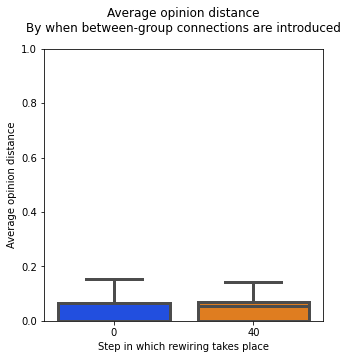

In [12]:
# Create a custom class which is based on the defSim.Simulation class
# All attributes and methods are copied, and we only modify the run_simulation() function
class SimulationWithRewiring(ds.Simulation):
    
    def run_simulation(self) -> pd.DataFrame:  # 
        self.initialize_simulation()   # always initialize the simulation
        
        if self.parameter_dict['rewiring_step'] == 0:   # condition where we immediately rewire the ties
            ds.MaslovSneppenModifier(rewiring_prop = 0.1).rewire_network(network = self.network)   # Rewire 10% of all ties
            self.dissimilarity_calculator.calculate_dissimilarity_networkwide(self.network)   # Recalculate dissimilarity to neighbors (would otherwise be missing for new ties)            
            for iteration in range(self.max_iterations):
                self.run_simulation_step()
        else:   # if we rewire the ties after a certain number of steps
            for iteration in range(self.parameter_dict['rewiring_step']):   # run upto rewiring step
                self.run_simulation_step()
            ds.MaslovSneppenModifier(rewiring_prop = 0.1).rewire_network(network = self.network)   # Rewire 10% of all ties
            self.dissimilarity_calculator.calculate_dissimilarity_networkwide(self.network)   # Recalculate dissimilarity to neighbors (would otherwise be missing for new ties)            
            for iteration in range(self.max_iterations - self.parameter_dict['rewiring_step']):
                self.run_simulation_step()
                
        return self.create_output_table()
    
# Now we can use the standard experiment class, as long as we provide a list of simulations
## Create a list of simulations
simulations = []
for i in range(100):
    seed = random.randint(1000, 9999)
    new_sim = ds.Simulation(
        seed = seed,
        influence_function = "bounded_confidence",  
        communication_regime = 'one-to-many',  
        attributes_initializer = "correlated_continuous",  
        dissimilarity_measure = "euclidean",  
        topology = "caveman_graph",  
        max_iterations = 80,   
        parameter_dict = {
            'l': 2,  
            'k': 10, 
            'confidence_level': 0.5, 
            'neighbor_similarity_postprocessing': 10,
            'neighbor_similarity_criterion': 0.4,   
        }
    )
    new_sim.parameter_dict['rewiring_step'] = 0 if i < 50 else 40
    simulations.append(new_sim)

## Create an experiment based on this list of simulations
experiment = ds.Experiment(
    simulations = simulations
)

# Run the experiment (where we can take advantage of parallel execution)
results = experiment.run(parallel = True)

# Show the average opinion distance for each experimental condition
print("Average opinion distance, rewiring_step == 0:", results.loc[results['rewiring_step'] == 0]['AverageDistance'].mean(axis=0))
print("Average opinion distance, rewiring_step == 40:", results.loc[results['rewiring_step'] == 40]['AverageDistance'].mean(axis=0))

# Make a plot showing distribution of average opinion distance in the experimental conditions
plot_experiment(results)